## Problem Statement

The objective of this project is to develop a robust and efficient semantic segmentation model to accurately identify and delineate brain tumors in medical images. Accurate segmentation of brain tumors is crucial for diagnostic purposes, treatment planning, and monitoring the progression of the disease. This task involves differentiating between healthy brain tissue and tumor regions, which can significantly aid radiologists and medical professionals in providing better patient care.

## Dataset Description

[Download Dataset Here](https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/data)

The dataset used in this project consists of medical images of brain scans annotated with brain tumor regions. Each image in the dataset is paired with a corresponding mask that highlights the tumor regions. The dataset is structured in the COCO format, which includes categories, images, and annotations.

- **Categories:** The dataset includes one category, "tumor," which represents the brain tumor regions in the images.
- **Images:** The images are medical brain scans, possibly including various imaging modalities like MRI or CT scans.
- **Annotations:** The annotations are in the form of binary masks where the pixel value of 1 indicates the presence of a tumor, and 0 indicates healthy brain tissue.

The dataset is divided into three subsets: training, validation, and testing. This division ensures that the model is trained on one subset, validated on another to tune hyperparameters, and tested on an unseen subset to evaluate its generalization performance.

## Install Necessary Libraries

To start, I install the required libraries. The `segmentation-models-pytorch` library is particularly useful as it provides pre-implemented models and utilities tailored for image segmentation tasks, which saves a lot of time and effort compared to implementing these models from scratch.

In [ ]:
! pip install segmentation-models-pytorch --quiet

If running on google colab uncomment the cell below

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import os
import json
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

## Config

Define the configuration parameters for the training process. These include paths to the dataset, device configuration (CPU or GPU), batch size, number of epochs, learning rate, and early stopping criteria. Setting these parameters helps manage the training process more effectively.

In [ ]:
config = {
    'train_path': None, # replace path
    'val_path': None,
    'test_path': None,
    'model_path': './best_model.pth',
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'batch_size': 32,
    'epochs': 100,
    'lr': 0.001,
    'patience': 7,
    'delta': 0.001,
}

## Gather Information from COCO File

Define a function to read the COCO annotation files and extract the relevant categories, images, and annotations. This step is crucial for understanding the structure and content of the dataset, which is necessary for training the model.

In [ ]:
def get_coco_ann(coco_file):
    with open(coco_file, 'r') as f:
        data = json.load(f)
    return data['categories'], data['images'], data['annotations']

train_coco = os.path.join(config['train_path'], '_annotations.coco.json')
val_coco = os.path.join(config['val_path'], '_annotations.coco.json')
test_coco = os.path.join(config['test_path'], '_annotations.coco.json')

train_coco_categories, train_coco_images, train_coco_annotations = get_coco_ann(train_coco)
val_coco_categories, val_coco_images, val_coco_annotations = get_coco_ann(val_coco)
test_coco_categories, test_coco_images, test_coco_annotations = get_coco_ann(test_coco)

## Segmentation Dataset

I create a custom dataset class for loading and preprocessing the brain tumor segmentation data. This class handles reading images and corresponding masks, resizing them, and applying necessary transformations. Using a custom dataset class allows me to have better control over how the data is loaded and preprocessed.

### Why Resizing is Important

Resizing the images is a crucial step for several reasons:

- **Uniformity:** Deep learning models, including U-Net, require input images of a fixed size. Resizing ensures that all images are of the same dimensions, which is necessary for batch processing.
- **Memory Management:** Resizing helps manage memory usage. Medical images, especially those from modalities like MRI and CT scans, can be very large. Resizing to a smaller, fixed size helps in fitting the data into GPU memory, enabling efficient training.
- **Performance:** Smaller image sizes can speed up the training process while still retaining essential features needed for segmentation.

U-Net specifically benefits from resized images because the network architecture involves downsampling and upsampling steps. Having a consistent image size helps in maintaining the spatial dimensions correctly throughout the network.


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, coco_images, annotations_info, base_path, img_size=(320, 320)):
        self.image_infos = coco_images
        self.annotations_info = annotations_info
        self.base_path = base_path
        self.img_size = img_size

    def __len__(self):
        return len(self.image_infos)

    def __getitem__(self, idx):
        image_info = self.image_infos[idx]
        img_path = os.path.join(self.base_path, image_info['file_name'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image not found at {img_path}")
            return None  # Skip this sample

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        for annotation in [ann for ann in self.annotations_info if ann['image_id'] == image_info['id']]:
            for segment in annotation['segmentation']:
                polygon = np.array(segment, dtype=np.int32).reshape((-1, 2))
                cv2.fillPoly(mask, [polygon], 1)  # Use 1 for the tumor class

        img_resized = cv2.resize(img, self.img_size)
        mask_resized = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
        img_normalized = img_resized.astype(np.float32) / 255.0
        mask_normalized = mask_resized.astype(np.int64)  # Ensure the mask is of type int64 for CrossEntropyLoss
        return img_normalized, mask_normalized

## DataLoaders

I create data loaders for the training, validation, and test sets. These loaders handle batching and shuffling of data for efficient training. Using data loaders helps streamline the data feeding process to the model, making training more efficient and manageable.

In [ ]:
train_dataset = SegmentationDataset(train_coco_images, train_coco_annotations, config['train_path'])
val_dataset = SegmentationDataset(val_coco_images, val_coco_annotations, config['val_path'])
test_dataset = SegmentationDataset(test_coco_images, test_coco_annotations, config['test_path'])

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)

## Early Stopping

Early stopping is a technique used during training to prevent overfitting. It monitors the model's performance on a validation set and stops the training process when the performance stops improving. This is particularly useful in scenarios where prolonged training can lead to the model fitting the noise in the training data rather than the underlying pattern.

### Benefits of Early Stopping

- **Prevents Overfitting:** By stopping the training process when the model's performance on the validation set no longer improves, early stopping helps prevent overfitting. This ensures that the model generalizes better to unseen data.
- **Saves Time and Resources:** Training deep learning models can be computationally expensive and time-consuming. Early stopping reduces the training time by stopping the process once further improvements are unlikely.
- **Improves Model Generalization:** Early stopping helps in achieving a balance between underfitting and overfitting, leading to a model that performs well on both the training and validation sets.

The `EarlyStopping` class below implements this technique. It monitors the Intersection over Union (IoU) score on the validation set and stops training if there is no improvement for a specified number of evaluations (`patience`). If a new best IoU score is achieved, the model is saved to the specified path.


In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_iou = None
        self.counter = 0
        self.early_stop = False
        self.path = path

    def __call__(self, val_iou, model):
        if self.best_iou is None:
            self.best_iou = val_iou
            self.save_checkpoint(val_iou, model)
        elif val_iou < self.best_iou + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early Stopping: IoU did not improve from {self.best_iou:.5f} for {self.patience} consecutive evaluations.")
        else:
            self.save_checkpoint(val_iou, model)
            self.best_iou = val_iou
            self.counter = 0

    def save_checkpoint(self, val_iou, model):
        if self.verbose:
            print(f'Saving a new best model at IoU {val_iou:.5f} to {self.path}\n')
        torch.save(model.state_dict(), self.path)

    def should_stop(self):
        return self.early_stop

## IoU Score Calculation

Intersection over Union (IoU) is a common evaluation metric used for image segmentation tasks. It measures the overlap between the predicted segmentation mask and the ground truth mask. The IoU score is defined as the ratio of the area of overlap to the area of union between the predicted and ground truth masks.

### IoU Score Equation

$$
\text{IoU} = \frac{|\text{Prediction} \cap \text{Ground Truth}|}{|\text{Prediction} \cup \text{Ground Truth}|}
$$

Where:
- $|\text{Prediction} \cap \text{Ground Truth}|$ is the area of overlap between the predicted mask and the ground truth mask.
- $|\text{Prediction} \cup \text{Ground Truth}|$ is the area of union between the predicted mask and the ground truth mask.

The `iou_score` function below calculates the IoU for each class and returns the average IoU over all classes. This implementation ensures that the IoU score is smooth and stable by adding a small constant (`smooth`) to the numerator and denominator.

### Why IoU is Important

- **Robust Metric:** IoU is a robust metric for evaluating segmentation models as it considers both false positives and false negatives.
- **Class Balance:** By computing IoU for each class and averaging, it ensures that the metric is not biased towards any particular class, especially in datasets with imbalanced class distributions.
- **Model Comparison:** IoU provides a clear and interpretable way to compare different segmentation models and select the best one based on performance.


In [ ]:
def iou_score(output, target, num_classes=2):
    smooth = 1e-6
    output = torch.argmax(output, dim=1)  # Get the predicted class
    target = target.long()  # Ensure target mask is also long
    iou = []
    for cls in range(num_classes):
        intersection = ((output == cls) & (target == cls)).float().sum()
        union = ((output == cls) | (target == cls)).float().sum()
        iou.append((intersection + smooth) / (union + smooth))
    return sum(iou) / num_classes  # Return the average IoU over the classes

## Training and Evaluation Functions

To train and evaluate the model, I define two functions: `train` and `evaluate`. These functions handle the forward pass, loss computation, backward pass, and optimization steps for training, as well as the performance evaluation on the validation set.

### Training Function

The `train` function performs the following steps:
1. **Set the model to training mode:** This enables certain layers, such as dropout and batch normalization, to behave differently during training compared to evaluation.
2. **Initialize running loss and IoU:** These variables keep track of the cumulative loss and IoU over the training epoch.
3. **Iterate over the training data:** For each batch, the images and masks are moved to the specified device (CPU or GPU).
4. **Forward pass:** The model generates predictions for the input images.
5. **Compute loss:** The loss between the predicted masks and ground truth masks is computed using the specified loss function.
6. **Backward pass and optimization:** The gradients are computed and the optimizer updates the model parameters.
7. **Update running loss and IoU:** The loss and IoU for the current batch are added to the cumulative totals.
8. **Return average loss and IoU:** The average loss and IoU over all batches are returned.

In [ ]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_iou = 0.0
    for images, masks in tqdm(loader, desc='Training'):
        images = images.permute(0, 3, 1, 2)
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_iou += iou_score(outputs, masks).item()
    average_loss = running_loss / len(loader)
    average_iou = total_iou / len(loader)
    return average_loss, average_iou

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Evaluating'):
            images = images.permute(0, 3, 1, 2)
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            total_iou += iou_score(outputs, masks).item()
    average_loss = running_loss / len(loader)
    average_iou = total_iou / len(loader)
    return average_loss, average_iou

## Model, Optimizer, and Loss Function

### Model: U-Net with ResNet34 Encoder

For the brain tumor segmentation task, I use a U-Net model with a ResNet34 encoder from the `segmentation_models_pytorch` library. U-Net is a popular architecture for image segmentation tasks due to its ability to capture both local and global context.

#### U-Net Architecture

U-Net consists of two main parts: an encoder (downsampling path) and a decoder (upsampling path).

1. **Encoder (Downsampling Path):**
    - The encoder is responsible for capturing the context of the image. It progressively reduces the spatial dimensions while increasing the number of feature channels.
    - In this implementation, the encoder is a pre-trained ResNet34 network, which is widely used due to its deep architecture and residual connections that help in training deep networks.

2. **Bottleneck:**
    - The bottleneck layer is the deepest part of the U-Net and connects the encoder and decoder. It captures the most abstract features of the input image.

3. **Decoder (Upsampling Path):**
    - The decoder is responsible for constructing the segmentation map by progressively increasing the spatial dimensions and reducing the number of feature channels.
    - It uses transposed convolutions (also known as deconvolutions) to upsample the feature maps.
    - Skip connections from the encoder layers are concatenated with the decoder layers to retain high-resolution features, which helps in producing precise segmentation boundaries.


### Loss Function: Cross-Entropy Loss

The loss function used for training the segmentation model is the Cross-Entropy Loss (`CrossEntropyLoss`). This loss function is appropriate for multi-class segmentation tasks.

#### Cross-Entropy Loss Equation

The Cross-Entropy Loss for a single sample is defined as:

$$
\text{CE}(p, y) = - \sum_{c=1}^{C} y_c \log(p_c)
$$

Where:
- $C$ is the number of classes.
- $y_c$ is the ground truth label for class $c$ (one-hot encoded).
- $p_c$ is the predicted probability for class $c$.

For a batch of samples, the Cross-Entropy Loss is averaged over all samples in the batch.

### Optimizer: Adam

The optimizer used for training the model is the Adam optimizer (`Adam`). Adam is an adaptive learning rate optimization algorithm that combines the advantages of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).

#### Adam Optimizer Equation

The update rule for the Adam optimizer for parameter $θ$ at time step $t$ is:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$
$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
$$
\theta_t = \theta_{t-1} - \frac{\alpha \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

Where:
- $m_t$ and $v_t$ are the first and second moment estimates.
- $\beta_1$ and $\beta_2$ are the exponential decay rates for the moment estimates.
- $\hat{m}_t$ and $\hat{v}_t$ are the bias-corrected moment estimates.
- $g_t$ is the gradient at time step $t$.
- $\alpha$ is the learning rate.
- $\epsilon$ is a small constant to prevent division by zero.

The Adam optimizer is chosen because it is computationally efficient, requires little memory, and works well for a wide range of deep learning problems.



In [ ]:
# Initialize the model, criterion, optimizer, early stopping
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', classes=2, activation=None).to(config['device'])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
early_stopping = EarlyStopping(patience=config['patience'], verbose=True, delta=config['delta'], path=config['model_path'])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 78.3MB/s]


## Training Loop

The training loop orchestrates the entire training process, including loading a saved model, training over multiple epochs, evaluating on the validation set, and implementing early stopping to prevent overfitting.

1. **Loading a Saved Model:**
    - Before starting the training, the code checks if there is a saved model from a previous training session. If a saved model exists, it loads the model's state to continue training from where it left off. This is useful for resuming training without losing progress.

2. **Training Over Multiple Epochs:**
    - The model is trained for a specified number of epochs (`n_epochs`). During each epoch, the `train` function is called to perform the forward pass, loss computation, backward pass, and optimization on the training data.
    - After training on the training data, the `evaluate` function is called to measure the model's performance on the validation set.

3. **Printing Progress:**
    - The training and validation loss and IoU are printed after each epoch to monitor the model's performance.

4. **Early Stopping:**
    - The `early_stopping` function is called with the validation IoU to check if the model's performance has improved. If not, a counter is incremented. When the counter exceeds the patience threshold, early stopping is triggered to halt training, preventing overfitting.
    - If early stopping is triggered, the training loop breaks out early.

In [ ]:
# Check if there's a saved model to continue training
if os.path.exists(config['model_path']):
    model.load_state_dict(torch.load(config['model_path']))
    print("Loaded model from previous checkpoint.")

# Train the model
n_epochs = config['epochs']
for epoch in range(n_epochs):
    train_loss, train_iou = train(model, train_loader, criterion, optimizer, config['device'])
    val_loss, val_iou = evaluate(model, val_loader, criterion, config['device'])
    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.5f} | Train IoU: {train_iou:.5f} | Val Loss: {val_loss:.5f} | Val IoU: {val_iou:.5f}\n")

    early_stopping(val_iou, model)
    if early_stopping.should_stop():
        break

Loaded model from previous checkpoint.


Evaluating: 100%|██████████| 13/13 [03:02<00:00, 14.01s/it]


Epoch: 1 | Train Loss: 0.01665 | Train IoU: 0.90890 | Val Loss: 0.07138 | Val IoU: 0.78360

Saving a new best model at IoU 0.78360 to drive/My Drive/Colab Notebooks/capstone/best_model.pth



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Epoch: 2 | Train Loss: 0.01901 | Train IoU: 0.90002 | Val Loss: 0.06347 | Val IoU: 0.76709



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Epoch: 3 | Train Loss: 0.01592 | Train IoU: 0.91381 | Val Loss: 0.05628 | Val IoU: 0.80578

Saving a new best model at IoU 0.80578 to drive/My Drive/Colab Notebooks/capstone/best_model.pth



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch: 4 | Train Loss: 0.01193 | Train IoU: 0.93210 | Val Loss: 0.06495 | Val IoU: 0.80271



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Epoch: 5 | Train Loss: 0.00982 | Train IoU: 0.94382 | Val Loss: 0.06090 | Val IoU: 0.80913

Saving a new best model at IoU 0.80913 to drive/My Drive/Colab Notebooks/capstone/best_model.pth



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch: 6 | Train Loss: 0.00893 | Train IoU: 0.94848 | Val Loss: 0.07618 | Val IoU: 0.79959



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


Epoch: 7 | Train Loss: 0.00802 | Train IoU: 0.95407 | Val Loss: 0.06470 | Val IoU: 0.81695

Saving a new best model at IoU 0.81695 to drive/My Drive/Colab Notebooks/capstone/best_model.pth



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch: 8 | Train Loss: 0.00757 | Train IoU: 0.95645 | Val Loss: 0.07751 | Val IoU: 0.80498



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Epoch: 9 | Train Loss: 0.00733 | Train IoU: 0.95749 | Val Loss: 0.07145 | Val IoU: 0.80603



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Epoch: 10 | Train Loss: 0.00677 | Train IoU: 0.96064 | Val Loss: 0.07277 | Val IoU: 0.81214



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Epoch: 11 | Train Loss: 0.00658 | Train IoU: 0.96181 | Val Loss: 0.07755 | Val IoU: 0.80470



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Epoch: 12 | Train Loss: 0.00641 | Train IoU: 0.96276 | Val Loss: 0.07868 | Val IoU: 0.80888



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


Epoch: 13 | Train Loss: 0.00594 | Train IoU: 0.96539 | Val Loss: 0.07579 | Val IoU: 0.80804



Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]

Epoch: 14 | Train Loss: 0.00594 | Train IoU: 0.96492 | Val Loss: 0.08728 | Val IoU: 0.80272

Early Stopping: IoU did not improve from 0.81695 for 7 consecutive evaluations.


## Evaluate

In [ ]:
# Function to evaluate the model on the test set
def test_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Testing'):
            images = images.permute(0, 3, 1, 2)
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            total_iou += iou_score(outputs, masks).item()
    average_loss = running_loss / len(loader)
    average_iou = total_iou / len(loader)
    return average_loss, average_iou



# Load the best model and evaluate on the test set
model.load_state_dict(torch.load(config['model_path']))
test_loss, test_iou = test_model(model, test_loader, criterion, config['device'])
print(f"Test Loss: {test_loss:.5f} | Test IoU: {test_iou:.5f}")

Testing: 100%|██████████| 6/6 [01:23<00:00, 13.90s/it]

Test Loss: 0.07201 | Test IoU: 0.80568


# Model Evaluation Results

The model evaluation on the test set resulted in the following metrics:

- **Test Loss**: 0.07201
- **Test IoU**: 0.80568

## Explanation

The function `test_model` is designed to evaluate the performance of a trained model on a test dataset. It calculates the average test loss and the Intersection over Union (IoU) score, which are crucial metrics in assessing the model's performance, particularly for tasks like image segmentation.

### Results Interpretation:

- **Test Loss (0.07201)**:
  - This value indicates how well the model's predictions match the ground truth masks on the test set. A lower loss signifies better performance.

- **Test IoU (0.80568)**:
  - The Intersection over Union (IoU) score is a metric used to evaluate the accuracy of the segmentation model. An IoU of 0.80568 means that, on average, the model's predicted segments overlap with the ground truth segments by approximately 80.57%, which is a strong performance indicator for segmentation tasks.


## Plot Predictions

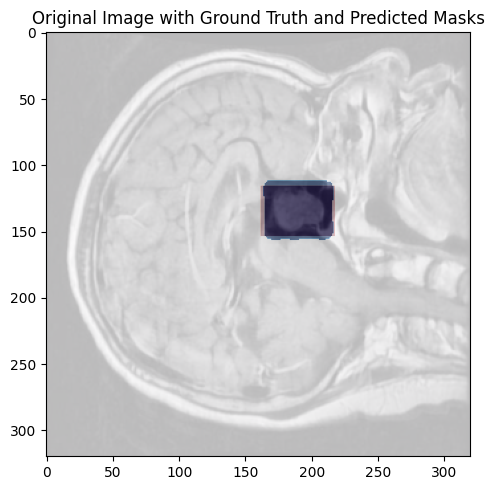

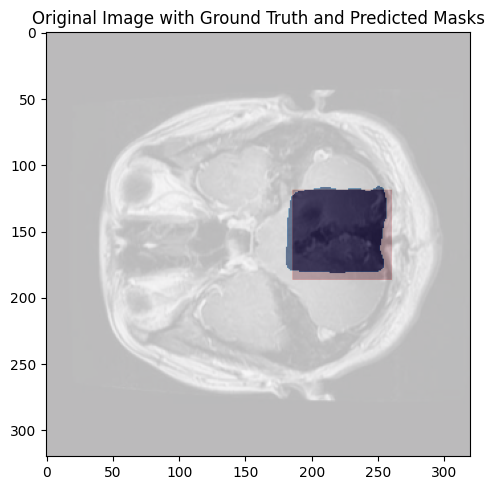

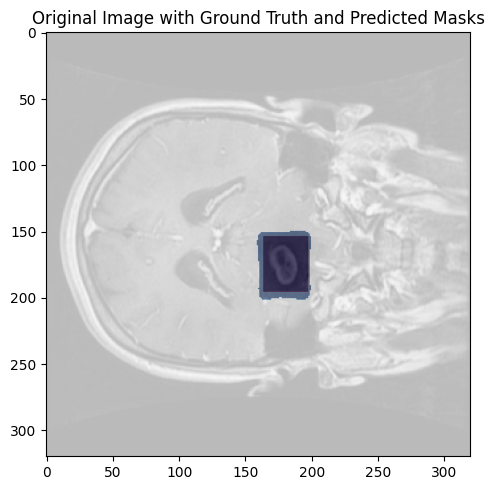

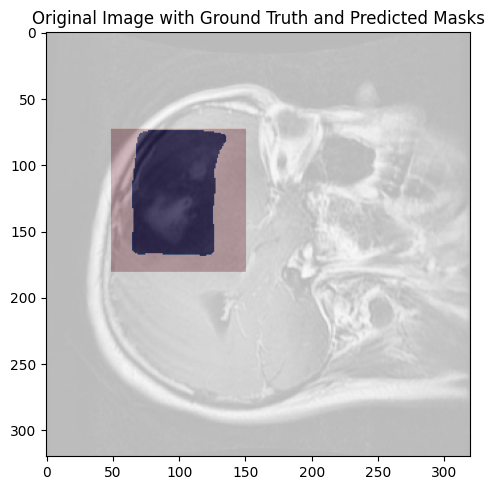

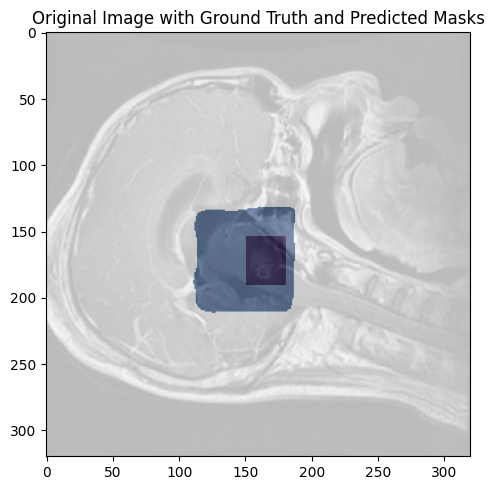

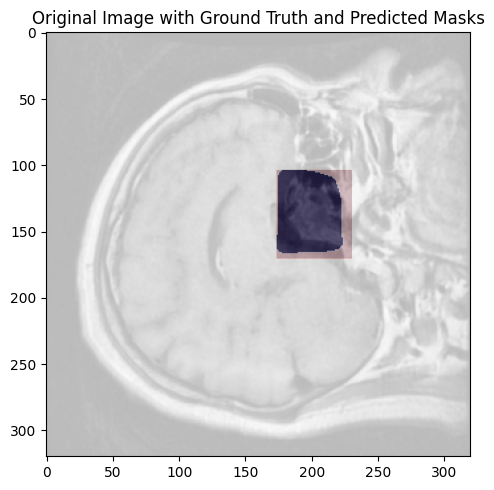

In [ ]:
# Function to plot predictions
def plot_predictions(model, loader, device, num_images=10):
    model.eval()
    images_to_plot = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            if i >= num_images:
                break
            images = images.permute(0, 3, 1, 2).to(device)
            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1).cpu().numpy()
            images = images.cpu().permute(0, 2, 3, 1).numpy()
            masks = masks.cpu().numpy()
            images_to_plot.append((images[0], masks[0], outputs[0]))

    for i, (image, mask, output) in enumerate(images_to_plot):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.imshow(image)
        ax.imshow(mask, cmap='Reds', alpha=0.5)
        ax.imshow(output, cmap='Blues', alpha=0.5)
        ax.set_title('Original Image with Ground Truth and Predicted Masks')
        plt.tight_layout()
        plt.show()

# Plot some predictions
plot_predictions(model, test_loader, config['device'])

## Model Predictions and Ground Truth Masks

The images above show the original input images from a medical imaging dataset overlaid with both the ground truth masks and the predicted masks generated by the segmentation model. The comparison helps to visually assess the model's performance in identifying the target regions within the medical images.


## Conclusion

The model demonstrates a strong performance in segmenting the medical images, as evidenced by the good overlap between the predicted and ground truth masks. This visual assessment supports the quantitative results obtained during testing, with a Test Loss of 0.07201 and a Test IoU of 0.80568. While there are some cases where the prediction could be improved, overall, the model effectively identifies the target regions within the medical images, making it a useful tool for medical image segmentation tasks.
